### GPU Setup and Library Installations

I am using `Tesla V100` from `Google Colab`.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec 16 09:40:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


Install all required libraries, 

1. `numpy` for `ndarray` operations
2. `matplotlib` for visualization
3. `pytorch` for model training
4. `torchvision` for data preprocessing

In [3]:
!pip install numpy
!pip install matplotlib

!pip install torch 
!pip install torchvision 

In [4]:
!pip show torchvision 
!pip show torch 

!pip show numpy
!pip show matplotlib

Name: torchvision
Version: 0.8.1+cu101
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: pillow, torch, numpy
Required-by: fastai
Name: torch
Version: 1.7.0+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, future, typing-extensions, dataclasses
Required-by: torchvision, torchtext, fastai
Name: numpy
Version: 1.18.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, 

Make sure that we use `GPU`.

In [5]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


### Dataset Preparations

I previously uploaded the `Columbia landmark` dataset into my `Google Drive`, consisting of three classes: 

1. `alma`
2. `lion`
3. `uris`

So, I need to `mount` and `copy` the dataset into the current working directory

In [6]:
 from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Create `data` directory

In [7]:
!mkdir data

Copy `train` and `val` images as separate directory

In [8]:
!cp -r "drive/MyDrive/DL for Comp Vis/Final Project/data/landmark" data

Sanity check how many data are in each dir, each class should have:

- $60$ training images
- $40$ validation images
- $20$ test images

In [9]:
!ls data/landmark/train/alma | wc -l

60


In [10]:
!ls data/landmark/train/uris | wc -l

60


In [11]:
!ls data/landmark/train/lion | wc -l

60


In [12]:
!ls data/landmark/val/alma | wc -l

40


In [13]:
!ls data/landmark/val/uris | wc -l

40


In [14]:
!ls data/landmark/val/lion | wc -l

40


In [15]:
!ls data/landmark/test/alma | wc -l

20


In [16]:
!ls data/landmark/test/uris | wc -l

20


In [17]:
!ls data/landmark/test/lion | wc -l

20


Imports

In [18]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

Transformation scheme

In [19]:
# Fix image size
IMAGE_SIZE = 224

# Augment using random rotation, flip and crop
train_transforms = transforms.Compose([
                           transforms.Resize(IMAGE_SIZE),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(IMAGE_SIZE, padding=10),
                           transforms.ToTensor(),
                       ])

# Don't augment the validation and test data
val_transforms = transforms.Compose([
                           transforms.Resize(IMAGE_SIZE),
                           transforms.ToTensor(),
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(IMAGE_SIZE),
                           transforms.ToTensor(),
                       ])

Load `train`, `val` and `test` data images from their respective directory using `ImageFolder`

In [20]:
train_data = datasets.ImageFolder("data/landmark/train", transform=train_transforms)

val_data = datasets.ImageFolder("data/landmark/val", transform=val_transforms)

test_data = datasets.ImageFolder("data/landmark/test", transform=test_transforms)

Sanity check 

In [21]:
print("Number of train data: {}".format(len(train_data)))
print("Number of val data: {}".format(len(val_data)))
print("Number of test data: {}".format(len(test_data)))

Number of train data: 180
Number of val data: 120
Number of test data: 60


Plot some images for each class

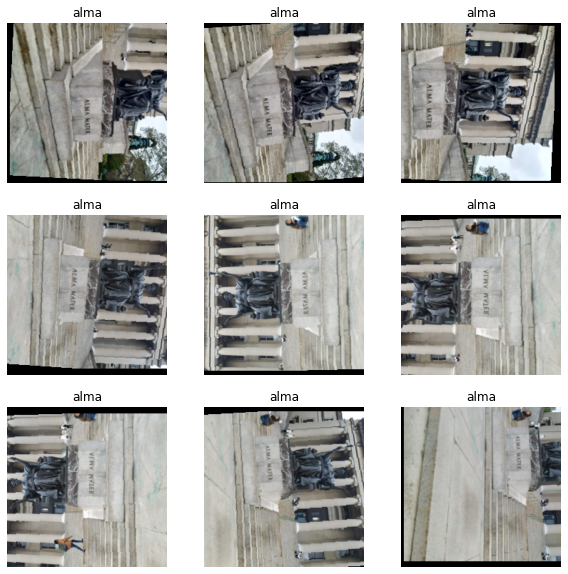

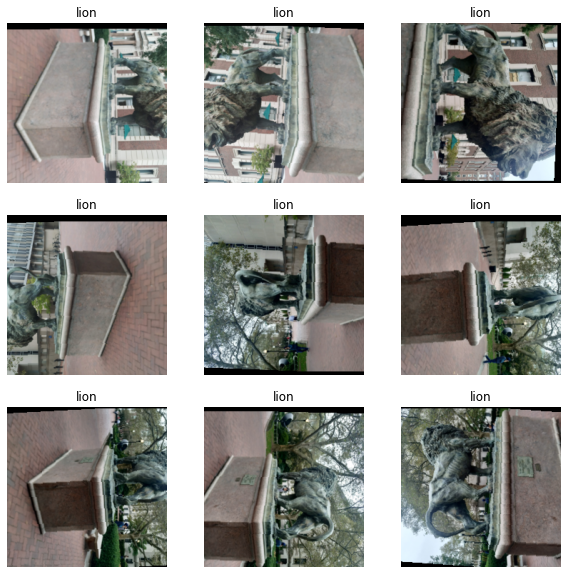

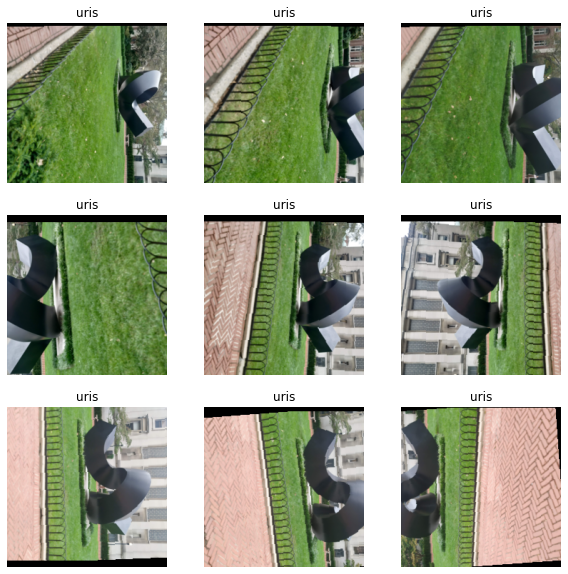

In [22]:
def plot_images(images, labels, classes):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

class_indexes = [
  np.arange(0, 10, 1),
  np.arange(len(train_data)//3, len(train_data)//3 + 10, 1),
  np.arange(len(train_data)//3*2, len(train_data)//3*2 + 10, 1)
]

classes = train_data.classes

for class_index in class_indexes:
  images, labels = zip(*[(image, label) for image, label in 
                            [train_data[i] for i in class_index]])

  plot_images(images, labels, classes)

Build `batch iterator` for `train` and `val`

In [23]:
BATCH_SIZE = 8

# Shuffle only for train data
train_iterator = data.DataLoader(train_data, 
                                 shuffle=True, 
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader(val_data, 
                               batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size=BATCH_SIZE)

### Building VGG Model

Set `seeds` for reproducibility

In [24]:
SEED = 82

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Loading `pre-trained VGG` models

In [25]:
import torchvision.models as models

model = models.vgg16(pretrained = True)

print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

Modifying `output` layer to have $3$ outputs, i.e. the number of classes

In [26]:
# Get the input and (new) output size
OUTPUT_DIM = 3
IN_FEATURES = model.classifier[-1].in_features 

# Create a new linear layer using the above
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

# Replace model output layer with newly created linear layer
model.classifier[-1] = final_fc

Sanity check

In [27]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


### Model Training

Hyperparameter setting:

1. Starting `learning rate`
2. Optimizer: `Adam`
3. Loss Criterion: `Cross Entropy Loss`

Here, we optimize all parameters as we perform `finetuning`

In [28]:
# Use a small learning rate to avoid oscillation
LR = 1e-4

# Use cross entropy loss since this is a multilabel classification problem
criterion = nn.CrossEntropyLoss()

# Since we finetune, we optimize all parameters, i.e.
# computing the gradients and updating those parameters
params = [
          {'params': model.parameters(), 'lr': LR},
         ]

# Use Adam optimizer
optimizer = optim.Adam(params, lr=LR)

# Use GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transfer model and loss criterion to GPU
model = model.to(device)
criterion = criterion.to(device)

Calculate accuracy function to be called in each epoch

In [29]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)

    correct = top_pred.eq(y.view_as(top_pred)).sum()

    return correct.float()/y.shape[0]

Train routine per epoch

In [30]:
def train(model, iterator, optimizer, criterion, device):
    
    # Train loss and acc to be cumulated over mini-batches
    epoch_loss = 0
    epoch_acc = 0
    
    # Set model to train mode, i.e. computing gradients
    model.train()
    
    # Iterating mini-batches
    for (x, y) in iterator:
        
        # Send input and label to GPU
        x = x.to(device)
        y = y.to(device)
        
        # Reset gradient
        optimizer.zero_grad()
                
        # Forward propagation, get prediction probabilities
        y_pred = model(x)

        # Compute loss, comparing the above to the label
        loss = criterion(y_pred, y)
        
        # Compute accuracy
        acc = calculate_accuracy(y_pred, y)
        
        # Backpropagation, computing the gradients
        loss.backward()
        
        # Updating optimized parameters
        optimizer.step()
        
        # Add cumulative loss/acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    # Return epoch loss and acc
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

Evaluate routine per epoch

In [31]:
def evaluate(model, iterator, criterion, device):

    # Validation loss and acc to be cumulated over mini-batches    
    epoch_loss = 0
    epoch_acc = 0
    
    # Set model to eval mode, i.e. turning off gradients computation
    model.eval()
  
    with torch.no_grad():

        # Iterating mini-batches      
        for (x, y) in iterator:

            # Send input and label to GPU
            x = x.to(device)
            y = y.to(device)

            # Forward propagation, get prediction probabilities
            y_pred = model(x)

            # Compute loss, comparing the above to the label
            loss = criterion(y_pred, y)

            # Compute accuracy
            acc = calculate_accuracy(y_pred, y)

            # Add cumulative loss/acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    # Return epoch loss and acc
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

Wall time per epoch

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time

    elapsed_mins = int(elapsed_time / 60)

    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

Train for 5 epochs

In [33]:
EPOCHS = 5

# Initialize best val_loss to biggest value possible
best_val_loss = float('inf')
best_val_acc = float(0)

# Placeholder for loss and acc per epoch
train_losses = []
val_losses = []

train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    
    # Clocking wall time    
    start_time = time.monotonic()
    
    # One epoch for train and evaluation
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_iterator, criterion, device)

    # Append the results
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'vgg16-finetune.pt')

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print("Epoch: {:02}, Time Elapsed: {} minutes, {} seconds".format(epoch+1, epoch_mins, epoch_secs))
    
    print("Train Loss: {:.4f}, Train Acc: {:.2f}".format(train_loss, train_acc*100))
    print("Val Loss: {:.4f}, Val Acc: {:.2f}".format(val_loss, val_acc*100))

    print("-"*50)

print("Best Val Loss: {:.4f}, Best Val Acc: {:.2f}".format(best_val_loss, best_val_acc*100))

Epoch: 01, Time Elapsed: 0 minutes, 58 seconds
Train Loss: 0.5355, Train Acc: 75.54
Val Loss: 0.0102, Val Acc: 99.17
--------------------------------------------------
Epoch: 02, Time Elapsed: 0 minutes, 56 seconds
Train Loss: 0.1562, Train Acc: 95.11
Val Loss: 0.0828, Val Acc: 95.00
--------------------------------------------------
Epoch: 03, Time Elapsed: 0 minutes, 58 seconds
Train Loss: 0.1229, Train Acc: 94.57
Val Loss: 0.0044, Val Acc: 100.00
--------------------------------------------------
Epoch: 04, Time Elapsed: 0 minutes, 59 seconds
Train Loss: 0.0871, Train Acc: 97.83
Val Loss: 0.0011, Val Acc: 100.00
--------------------------------------------------
Epoch: 05, Time Elapsed: 0 minutes, 57 seconds
Train Loss: 0.0277, Train Acc: 98.91
Val Loss: 0.0002, Val Acc: 100.00
--------------------------------------------------
Best Val Loss: 0.0002, Best Val Acc: 100.00


Training and Validation Loss Plot

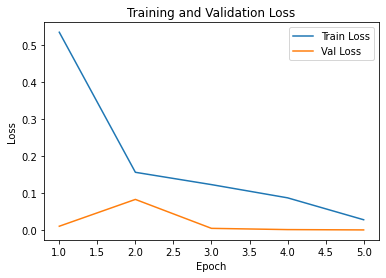

In [34]:
epochs = np.arange(1, EPOCHS+1, dtype="int32")

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Training and Validation Loss")

plt.legend()

plt.show()

Training and Validation Accuracy Plot

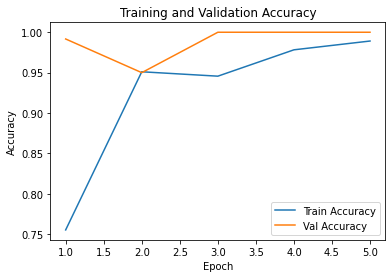

In [35]:
epochs = np.arange(1, EPOCHS+1, dtype="int32")

plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Val Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("Training and Validation Accuracy")

plt.legend()

plt.show()

Save the model to `Google Drive`

In [36]:
!cp vgg16-finetune.pt "drive/MyDrive/DL for Comp Vis/Final Project/models/landmark/"

### Model Inference

Inference routine

In [37]:
def get_predictions(model, iterator):

    # Set model to eval mode, i.e. turning off gradients computation
    model.eval()

    # Placeholders
    images = []
    labels = []
    probs = []

    with torch.no_grad():

        # Iterating test mini-batches
        for (x, y) in iterator:

            # Send image to GPU
            x = x.to(device)

            # Get prediction probabilities
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            # Get the top-1
            top_pred = y_prob.argmax(1, keepdim=True)

            # Send back to CPU
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    return torch.cat(images, dim=0), torch.cat(labels, dim=0), torch.cat(probs, dim = 0)

Predict from `test` data

In [38]:
images, labels, probs = get_predictions(model, test_iterator)

pred_labels = torch.argmax(probs, 1)

Plot `confusion matrix` to see how the model performs for each class in `test` set

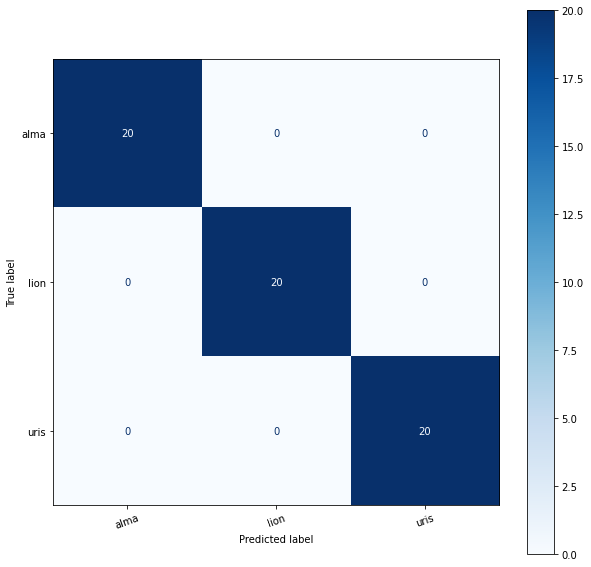

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));

    ax = fig.add_subplot(1, 1, 1);

    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);

    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

    plt.xticks(rotation = 20)

plot_confusion_matrix(labels, pred_labels, classes)

We can see that ...

Finding out incorrect predictions

In [40]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

print("Number of incorrect predictions: {}".format(len(incorrect_examples)))

Number of incorrect predictions: 0


Plot incorrect predictions, sorted from the most confident

In [41]:
# def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

#     rows = int(np.sqrt(n_images))
#     cols = int(np.sqrt(n_images))

#     fig = plt.figure(figsize = (25, 20))

#     for i in range(rows*cols):

#         ax = fig.add_subplot(rows, cols, i+1)
        
#         image, true_label, probs = incorrect[i]
#         image = image.permute(1, 2, 0)
#         true_prob = probs[true_label]
#         incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
#         true_class = classes[true_label]
#         incorrect_class = classes[incorrect_label]

#         if normalize:
#             image = normalize_image(image)

#         ax.imshow(image.cpu().numpy())
#         ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
#                      f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
#         ax.axis('off')
        
#     fig.subplots_adjust(hspace = 0.4)

# N_IMAGES = 5

# plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

### Learned Filters

It is also interesting to see what each `VGG` filter learns.

In [42]:
def plot_filtered_images(images, filters, n_filters=None):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see below that the learned `filters` do different types of `edge detection`, `color inversion` and `blurring` for each class of the image.

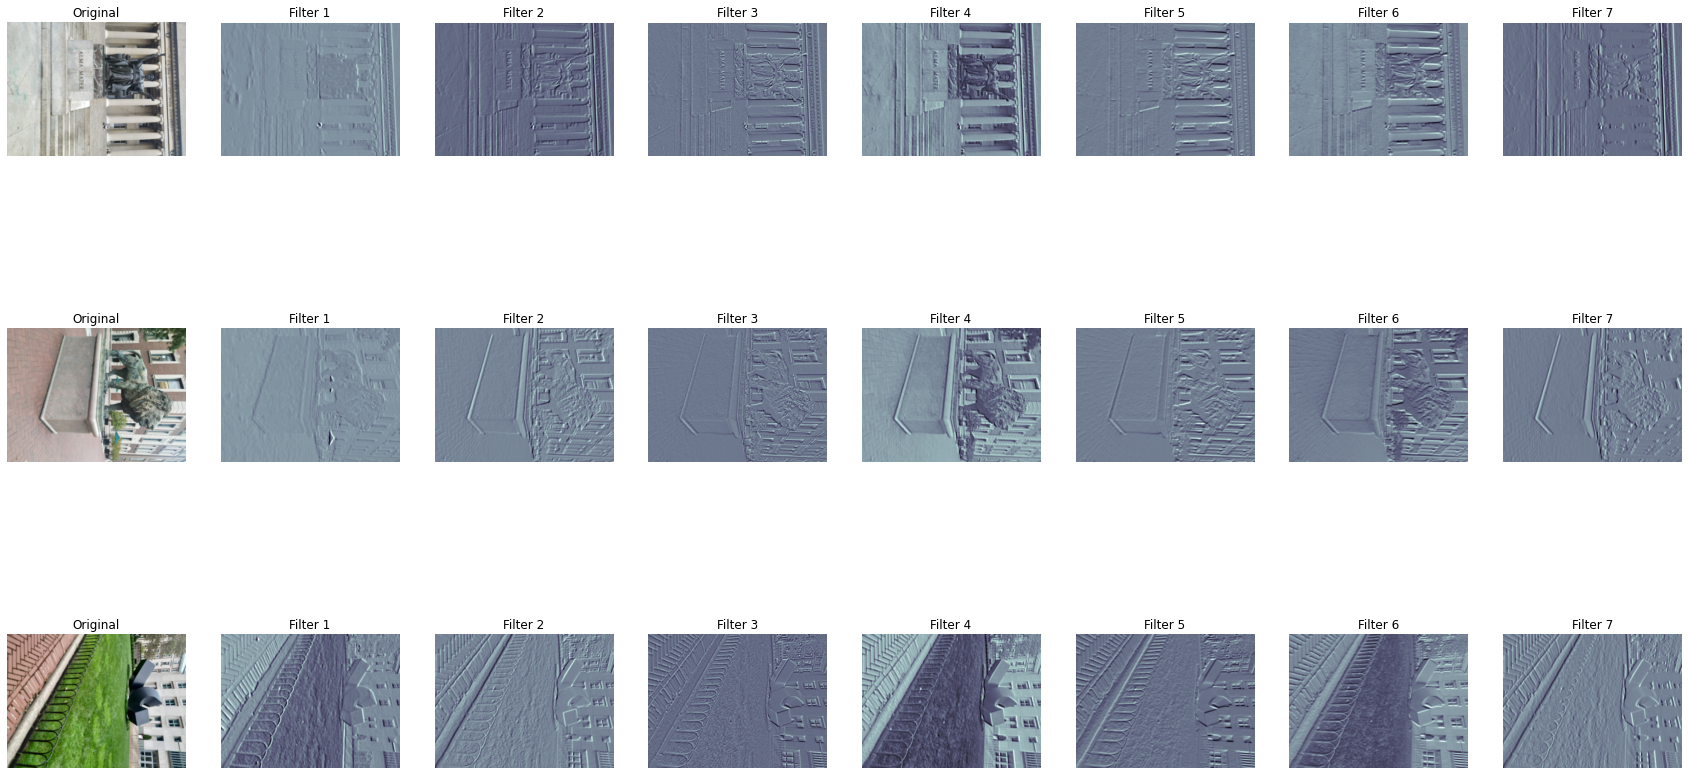

In [43]:
N_IMAGES = 3
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in [1, 25, 50]]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

Meanwhile, below is the plot of the actual `filter weights`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

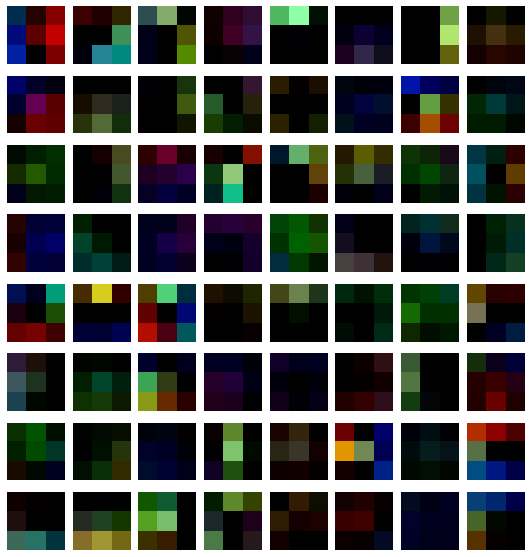

In [44]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)

plot_filters(filters)